In [176]:
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
import sqlite3 as lite
import os
import sys
#from matplotlib import pyplot as plt
import numpy as np
import statsmodels.api as sm
#%matplotlib inline
from collections import Counter
import itertools

In [177]:
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/43.0.2357.124 Safari/537.36'}

In [441]:
cities = [['tx', "austin"] ,[ 'ca' , 'los-angeles'] ,[ 'ga' , 'atlanta'] ,[ 'ma' , 'boston'] ,[ 'nc' , 'charlotte'] ,[ 'tx' , 'dallas'] ,[ 'co' , 'denver'] ,[ 'tx' , 'houston'] ,[ 'fl' , 'miami'] ,[ 'mn' , 'minneapolis'] ,[ 'ny' , 'new-york'] ,[ 'pa' , 'philadelphia'] ,[ 'az' , 'phoenix'] ,[ 'or' , 'portland'] ,[ 'ca' , 'san-francisco'] ,[ 'ca' , 'san-diego'] ,[ 'wa' , 'seattle'] ,[ 'dc' , 'washington'] ]

In [444]:
# CRAWL ALL THE PAGES OF INTEREST
datadir = 'crawl/'
if not(os.path.isdir(datadir)):
    os.makedirs(datadir)

for city in cities:
    k = city[0]
    v = city[1]
    running = True
    page = 1
    print ''
    print k,v
    while running:
        url = "https://dogvacay.com/dog-boarding--" + k + "--" + v + "?p="+str(page)
        filename = datadir + k + '-' + v + '-' + str(page) + '.htm'
        if not(os.path.isfile(filename)):
            sys.stdout.write('-')
            r = requests.get(url, headers=headers)
            time.sleep(1)
            f = open(filename, 'w')
            f.write(r.text.encode('ascii', 'replace'))
            f.close()
            data = r.text
        else:
            sys.stdout.write('.')
            f = open(filename, 'r')
            data = f.read()
            f.close()
        soup = BeautifulSoup(data)
        pagination_links = soup.findAll('a', {'class': 'pagination-link dv-button'})
        #running = False
        for pl in pagination_links:
            if 'Next' in pl:
                running = True
            else:
                running = False
        page+=1



tx austin
----------
ca los-angeles
------
ga atlanta
-------
ma boston
-----------
nc charlotte
------
tx dallas
---
co denver
---------------------------------------------

KeyboardInterrupt: 

In [415]:
# Data extraction phase

times = []
fees = []
reviews = []
repeats = []
city = []
service = []
rating = []
name = []
security = []
instant = []
dog = []


for src in os.listdir(datadir):
    filename = datadir + src
    print 'Processing: ' + filename
    f = open(filename, 'r')
    data = f.read()
    f.close()
    soup = BeautifulSoup(data)
    sitters = soup.findAll(lambda tag:tag.name == "div" and \
                           len(tag.attrs) == 1 and \
                           tag.attrs.keys()[0] == "search-list-item")
    for sitter in sitters:
        rtwrap = sitter.findAll('li', {'class': 'dv-search-badge-item'})
        if len(rtwrap) > 0:
            response_time = rtwrap[0].text.strip('\n')#[18:]
        else:
            response_time = -1
        fee = sitter.findAll('span', {'class': "dv-host-list-item__price__amount"})[0].text.strip()[1:3] #Need to fix in case of triple digit prices
        review = sitter.find('span', {'class': 'dv-host-review'})
        if review is not None and len(review) > 0:
            review = int(review.text.replace('Reviews', '').replace('Review', '').strip())
        else:
            review = 0
        rpwrap = sitter.findAll('span', {'class': 'dv-host-repeat'})
        if len(rpwrap) == 1: # and len(repeat.strip()) > 12:
            repeat = rpwrap[0].text.strip()[:2]
        else:
            repeat = 0
        names = sitter.find('a', {'class': 'dv-host-list-item__body__link'}).text#.strip('\n$').split(' ')
        services = sitter.findAll('div', {'class': 'dv-host-list-item__info dv-host-list-item__services'})[0].text.strip()
        full_star = sitter.findAll('i', {'class':" dv-icon dv-icon__star "})
        ratings = len(full_star)
        half_star = sitter.findAll('i', {'class': " dv-icon dv-icon__star-half "})
        if len(half_star) > 0:
            ratings += .5
        title = soup.findAll('span', {'class': "dv-hero__title__location"})[0].text.strip()
        lightning = sitter.findAll('i', {'class': 'dv-icon dv-icon__instantbook'})
        if len(lightning) > 0:
            instabook = 1
        else:
            instabook = 0
        truid = sitter.findAll('i', {'class': 'dv-icon dv-icon__background-checked'})
        if len(truid) > 0:
            background = 1
        else:
            background = 0
        dogowner = sitter.findAll('i', {'class': 'dv-icon dv-icon__dog-face'})
        if len(dogowner) > 0:
            dogowner = 1
        else:
            dogowner = 0
        instant.append(instabook)
        times.append(response_time)
        fees.append(fee)
        reviews.append(review)
        repeats.append(repeat)
        city.append(title)
        name.append(names)
        rating.append(ratings)
        service.append(services)#.text.strip('\n'))
        security.append(background)
        dog.append(dogowner)
    
#Dataframe from dict of objects 
df = pd.DataFrame({'ratings': rating,
                   'services' : service, 
                   'names': name, 
                   'title':city, 
                   'response_time': times, 
                   'fee':fees, 'review':reviews,
                   'repeat':repeats, 
                   'background':security, 
                   'instabook':instant, 
                   'dogowner':dog})

Processing: crawl/tx-austin-1.htm
Processing: crawl/tx-austin-2.htm


In [416]:
df.head()

,background,dogowner,fee,instabook,names,ratings,repeat,response_time,review,services,title
0,1,1,50,0,E. 7th St. to Downtown & Airport!!!,5,6,Responds in 5 minutes,18,Boarding & Daycare,"Austin, TX"
1,1,0,35,0,South Congress Boarding,0,0,Responds in 12 hours,0,"Boarding, Daycare, Walking, Checkups and Visit...","Austin, TX"
2,1,1,25,1,Pet Sitter/Boarding With Pup Friend,0,0,Responds in 10 minutes,0,"Boarding, Daycare, Checkups and Visits, Bathin...","Austin, TX"
3,0,0,35,0,Emily in South Austin,0,0,Responds in 2 hours,0,"Boarding, Daycare, Walking, & Pick up and Drop...","Austin, TX"
4,0,1,40,0,Fun in the Hills,5,10,Responds in 40 minutes,12,"Boarding, Daycare, & Pick up and Drop off","Austin, TX"


In [186]:
s = sitters[0]

In [294]:
badge_selector = "li.dv-search-badge-item"

In [328]:
def parse_breed_list(breed_list):
    """
    Get breed names and counts from website text.
    
    Arguments
    ---------
    breed_list: list
        Text of breed list scraped from web site.
        
    Returns
    -------
    breed_info: list of tuples
    
    Example
    -------
    >>> parse_breed_list([u'an Other and 2 Australian Cattle Dogs'])
    [('Other', 1), ('Australian Cattle Dog', 2)]
    >>> parse_breed_list([])
    []
    """
    if len(breed_list) == 0:
        return []
    breed_info = []
    #Split into list of indiv. breeds
    breeds = breed_list[0].split(' and ')
    #Split quantity from breed name on 1st space
    for breed in breeds:
        quantity, name = breed.split(' ', 1)
        if quantity[0] == 'a':  # 'a' or 'an' means 1
            quantity = '1'
        quantity = int(quantity)
        if quantity > 1 and name[-1] == 's':
            name = name[:-1]
        breed_info.append((name, quantity))
    return breed_info

In [295]:
sitter_badges = [s.select(badge_selector) for s in sitters]

In [334]:
sitter_breeds = []
for sb in sitter_badges:
    breeds = [b.get_text().strip('\n').replace('Owns ', '') for b in sb if breed_class in str(b)]
    sitter_breeds.append(breeds)

In [350]:
[parse_breed_list(sb) for sb in sitter_breeds]

[[],
 [],
 [(u'Chihuahua', 1)],
 [(u'Golden Retriever', 1)],
 [(u'Chihuahua', 3)],
 [(u'Mixed', 1)],
 [(u'Other', 1), (u'Australian Cattle Dog', 2)],
 [],
 [(u'Mixed Breed', 1)],
 [(u'Portuguese Water Dog', 1), (u'Shih Tzu', 1)],
 [(u'Chihuahua', 1), (u'Beagle', 1)],
 [(u'Labrador Retriever', 1)],
 [(u'Dachshund', 1)],
 [(u'Lhasa Apso', 1)],
 []]

In [417]:
#eliminate trailing spaces from response_time
df['response_time'] = df['response_time'].apply(lambda x: str(x).strip())

In [418]:
#separate services
df['boarding'] = df['services'].map(lambda x: 1 if "Boarding" in x else 0)
df['sitting'] = df['services'].map(lambda x: 1 if "Sitting" in x else 0)
df['daycare'] = df['services'].map(lambda x: 1 if "Daycare" in x else 0)
df['checkups'] = df['services'].map(lambda x: 1 if "Checkups and Visits" in x else 0)
df['walking'] = df['services'].map(lambda x: 1 if "Walking" in x else 0)
df['bathing'] = df['services'].map(lambda x: 1 if "Bathing" in x else 0)
df['training'] = df['services'].map(lambda x: 1 if "Training" in x else 0)
df['grooming'] = df['services'].map(lambda x: 1 if "Grooming" in x else 0)
df['pickup/dropoff'] = df['services'].map(lambda x: 1 if "Pick up and Drop off" in x else 0)

In [419]:
#response time
df['response_time'] = df['response_time'].map(lambda x: 1 if x == 'Few Hours' else 2 if x == 'Day' else 3)

In [420]:
df.ix[df['fee']=='', 'fee'] = 0

In [421]:
df["fee"] = df["fee"].astype(float)
df["repeat"] = df["repeat"].astype(int)

In [422]:
df['services'] = df['boarding']+df['sitting']+df['daycare']+df['checkups']+df['walking']+df['bathing']+df['training']+df['grooming']+df['pickup/dropoff']

In [423]:
df.head()

,background,dogowner,fee,instabook,names,ratings,repeat,response_time,review,services,title,boarding,sitting,daycare,checkups,walking,bathing,training,grooming,pickup/dropoff
0,1,1,50,0,E. 7th St. to Downtown & Airport!!!,5,6,3,18,2,"Austin, TX",1,0,1,0,0,0,0,0,0
1,1,0,35,0,South Congress Boarding,0,0,3,0,4,"Austin, TX",1,0,1,1,1,0,0,0,0
2,1,1,25,1,Pet Sitter/Boarding With Pup Friend,0,0,3,0,4,"Austin, TX",1,0,1,1,0,1,0,0,0
3,0,0,35,0,Emily in South Austin,0,0,3,0,4,"Austin, TX",1,0,1,0,1,0,0,0,1
4,0,1,40,0,Fun in the Hills,5,10,3,12,3,"Austin, TX",1,0,1,0,0,0,0,0,1


In [19]:
# SAVE TO CSV FILE
df.to_csv('dog-vacay.csv', encoding='ascii')

In [29]:
#Create a scatter plot matrix
a = pd.scatter_matrix(df, alpha=.05, figsize=(10,10))
plt.show()

RuntimeError: Python is not installed as a framework. The Mac OS X backend will not be able to function correctly if Python is not installed as a framework. See the Python documentation for more information on installing Python as a framework on Mac OS X. Please either reinstall Python as a framework, or try one of the other backends. If you are Working with Matplotlib in a virtual enviroment see 'Working with Matplotlib in Virtual environments' in the Matplotlib FAQ

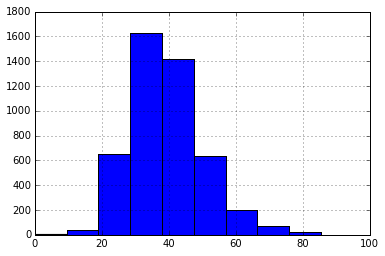

In [16]:
#Histogram of fees
p = df['fee'].hist()
plt.show()

In [30]:
#Extract columns
fee = df['fee']
repeat = df['repeat']
ratings = df['ratings']

In [31]:
#The dependent variable
y = np.matrix(fee).transpose()
#The independent variable
x1 = np.matrix(repeat).transpose()
x2 = np.matrix(rating).transpose()

In [32]:
x = np.column_stack([x1, x2])

In [33]:
X = sm.add_constant(x)
model = sm.OLS(y,X)
f = model.fit()
f.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.939
Date:                Sun, 20 Mar 2016   Prob (F-statistic):             0.0195
Time:                        16:03:59   Log-Likelihood:                -24694.
No. Observations:                6162   AIC:                         4.939e+04
Df Residuals:                    6159   BIC:                         4.941e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         37.9596      0.265    143.090      0.000        37.440    38.480
x1             0.0682      0.097      0.706      0.480        -0.121     0.258
x2            -0.2177      0.081     -2.693      0.007        -0.376    -0.059
==============================================================================
Omnibus:                     7881.923   Durbin-Watson:                   1.685
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          6435303.096
Skew:                           6.424   Prob(JB):                         0.00
Kurtosis:                     160.795   Cond. No.                         6.88
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
#df.groupby('repeat').mean()

In [37]:
#df.groupby('repeat').median()

In [123]:
#df.groupby('services').median()

In [122]:
#df.groupby('services').mean()

In [117]:
#df.groupby('review').median()

In [118]:
#atx.groupby('review').median()

In [119]:
#sea.groupby('review').median()

In [183]:
#df.groupby('city').mean()

In [184]:
#df.groupby('city').median()